In [92]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sbn

In [103]:
df = pd.read_csv('dataset/train.csv')

In [104]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from scipy.stats import mode
import string

def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if string.find(big_string, substring) != -1:
            return substring
    print (big_string)
    return np.nan


def phase1clean(df):
    #setting silly values to nan
    df.Fare = df.Fare.map(lambda x: np.nan if x==0 else x)
    
    #Special case for cabins as nan may be signal
    df.Cabin = df.Cabin.fillna('Unknown')    

    #creating a title column from name
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']

    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))
    
    #replacing all titles with mr, mrs, miss, master
    def replace_titles(x):
        title=x['Title']
        if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Countess', 'Mme']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        else:
            return title
    df['Title']=df.apply(replace_titles, axis=1)

    #Turning cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    df['Deck']=df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
        
    #Creating new family_size column
    df['Family_Size']=df['SibSp']+df['Parch']
    
    return df
    
def phase2clean(train, test):
    #data type dictionary
    data_type_dict={'Pclass':'ordinal', 'Sex':'nominal', 
                    'Age':'numeric', 
                    'Fare':'numeric', 'Embarked':'nominal', 'Title':'nominal',
                    'Deck':'nominal', 'Family_Size':'ordinal'}      

    #imputing nan values
    for df in [train, test]:
        classmeans = df.pivot_table('Fare', rows='Pclass', aggfunc='mean')
        df.Fare = df[['Fare', 'Pclass']].apply(lambda x: classmeans[x['Pclass']] if pd.isnull(x['Fare']) else x['Fare'], axis=1 )
        meanAge=np.mean(df.Age)
        df.Age=df.Age.fillna(meanAge)
        modeEmbarked = mode(df.Embarked)[0][0]
        df.Embarked = df.Embarked.fillna(modeEmbarked)


#    Fare per person
    for df in [train, test]:
        df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)
    
    #Age times class
    for df in [train, test]:
        df['Age*Class']=df['Age']*df['Pclass']
    
    data_type_dict['Fare_Per_Person']='numeric'
    data_type_dict['Age*Class']='numeric'
    
    return [train,test, data_type_dict]
    
def discretise_numeric(train, test, data_type_dict, no_bins=10):
    N=len(train)
    M=len(test)
    test=test.rename(lambda x: x+N)
    joint_df=train.append(test)
    for column in data_type_dict:
        if data_type_dict[column]=='numeric':
            joint_df[column]=pd.qcut(joint_df[column], 10)
            data_type_dict[column]='ordinal'
    train=joint_df.ix[range(N)]
    test=joint_df.ix[range(N,N+M)]
    return train, test, data_type_dict

def clean(no_bins=0):
    #you'll want to tweak this to conform with your computer's file system
    trainpath = 'dataset/train.csv'
    testpath = 'dataset/test.csv'
    traindf = pd.read_csv(trainpath)
    testdf = pd.read_csv(testpath)

    traindf=phase1clean(traindf)
    testdf=phase1clean(testdf)
    
    traindf, testdf, data_type_dict=phase2clean(traindf, testdf)
    
    traindf, testdf, data_type_dict=discretise_numeric(traindf, testdf, data_type_dict)

    
    #create a submission file for kaggle
    predictiondf = pd.DataFrame(testdf['PassengerId'])
    predictiondf['Survived']=[0 for x in range(len(testdf))]
    predictiondf.to_csv('prediction.csv',
                  index=False)
    return [traindf, testdf, data_type_dict]


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [115]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))
 
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
df['Title']=df.apply(replace_titles, axis=1)

AttributeError: module 'string' has no attribute 'find'

In [2]:
x = pd.read_csv('dataset/train.csv')
y = x.pop('Survived')

In [3]:
x.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [5]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [6]:
x['Age'].value_counts(dropna=False).head()

NaN      177
 24.0     30
 22.0     27
 18.0     26
 28.0     25
Name: Age, dtype: int64

In [7]:
x['Age'].fillna(x['Age'].mean(), inplace=True)

In [8]:
x['Embarked'].value_counts(dropna=False).head()

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [9]:
x['Embarked'].fillna('S', inplace=True)

In [10]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [11]:
x.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
del x['Name']

In [13]:
del x['Ticket']

In [14]:
del x['PassengerId']

In [15]:
del x['Fare']

In [16]:
#x = x.fillna(0)
x.head()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,3,male,22.0,1,0,NaN,S
1,1,female,38.0,1,0,C85,C
2,3,female,26.0,0,0,NaN,S
3,1,female,35.0,1,0,C123,S
4,3,male,35.0,0,0,NaN,S


In [17]:
# convert sex categorical to numeric
x['Sex'].replace(['female','male'],[0,1],inplace=True)

In [18]:
x.head()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,3,1,22.0,1,0,NaN,S
1,1,0,38.0,1,0,C85,C
2,3,0,26.0,0,0,NaN,S
3,1,0,35.0,1,0,C123,S
4,3,1,35.0,0,0,NaN,S


In [19]:
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return 'None'
x['Cabin'] = x['Cabin'].apply(clean_cabin)


In [20]:
x['Cabin'].head()

0    None
1       C
2    None
3       C
4    None
Name: Cabin, dtype: object

In [21]:
#x.fillna(0)
x['Cabin'].value_counts(dropna=False).head()

None    687
C        59
B        47
D        33
E        32
Name: Cabin, dtype: int64

In [22]:
x.head()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,3,1,22.0,1,0,None,S
1,1,0,38.0,1,0,C,C
2,3,0,26.0,0,0,None,S
3,1,0,35.0,1,0,C,S
4,3,1,35.0,0,0,None,S


In [23]:
x['Age'].value_counts(dropna=False).head()

29.699118    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
Name: Age, dtype: int64

In [24]:
x['Age'].value_counts(dropna=False)

29.699118    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
30.000000     25
19.000000     25
21.000000     24
25.000000     23
36.000000     22
29.000000     20
35.000000     18
26.000000     18
32.000000     18
27.000000     18
31.000000     17
16.000000     17
23.000000     15
34.000000     15
33.000000     15
20.000000     15
39.000000     14
40.000000     13
42.000000     13
17.000000     13
45.000000     12
38.000000     11
4.000000      10
50.000000     10
2.000000      10
            ... 
0.830000       2
30.500000      2
0.750000       2
57.000000      2
55.000000      2
70.000000      2
10.000000      2
32.500000      2
71.000000      2
63.000000      2
28.500000      2
45.500000      2
40.500000      2
59.000000      2
14.500000      1
0.670000       1
12.000000      1
0.920000       1
74.000000      1
34.500000      1
70.500000      1
36.500000      1
24.500000      1
66.000000      1
80.000000      1
55.500000      1
53.000000      1
20.500000     

In [25]:
def age_band(dl):
    if  dl <= 10.0 : return 'Age_band_1'
    elif 10.0 < dl <= 20.0 : return 'Age_band_2'
    elif 20.0 < dl <= 30.0 : return 'Age_band_3'
    elif 30.0 < dl <= 40.0 : return 'Age_band_4'
    elif 40.0 < dl <= 50.0 : return 'Age_band_5'
    elif 50.0 < dl <= 60.0 : return 'Age_band_6'
    elif 60.0 < dl <= 70.0 : return 'Age_band_7'
    elif 70.0 < dl <= 80.0 : return 'Age_band_8'
    elif 80.0 < dl <= 90.0 : return 'Age_band_9'
    elif 90.0 < dl <= 100.0 : return 'Age_band_10'

x['Age'] = x['Age'].map(age_band)

In [26]:
x['Age'].value_counts(dropna=False)

Age_band_3    407
Age_band_4    155
Age_band_2    115
Age_band_5     86
Age_band_1     64
Age_band_6     42
Age_band_7     17
Age_band_8      5
Name: Age, dtype: int64

In [29]:
# sbn.pairplot(x, kind = 'reg')

In [30]:
#(x['Fare']>290).value_counts(dropna=False)

In [31]:
# create dummy variables at a time for all categorical variable

categorical_variable = ['Age','Pclass','Cabin','Embarked']

for variable in categorical_variable:
    # create missing data wirth 'Missing' world
    x[variable].fillna('Missing', inplace=True)
    # Create array od fummys
    dummies = pd.get_dummies(x[variable], prefix=variable)
    # Update  x to tindicate dummies and drop the main variable
    
    x= pd.concat([x, dummies], axis=1)
    x.drop([variable], axis=1, inplace=True)
    

In [32]:
x.head()

,Sex,SibSp,Parch,Age_Age_band_1,Age_Age_band_2,Age_Age_band_3,Age_Age_band_4,Age_Age_band_5,Age_Age_band_6,Age_Age_band_7,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [33]:
del x['Cabin_T']

In [34]:
x.head()

,Sex,SibSp,Parch,Age_Age_band_1,Age_Age_band_2,Age_Age_band_3,Age_Age_band_4,Age_Age_band_5,Age_Age_band_6,Age_Age_band_7,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Embarked_C,Embarked_Q,Embarked_S
0,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [35]:
type(x)

pandas.core.frame.DataFrame

In [36]:
#x['Fare'].plot(kind='scatter', figsize=(7,6))
# N=50 l = plt.scatter(x['Fare'],l)
#sbn.pairplot(x, kind = 'reg')

In [37]:
model = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(x,y)
print('C-stat', roc_auc_score(y, model.oob_prediction_))

C-stat 0.829969961333


In [38]:
model.feature_importances_
srt =pd.Series(model.feature_importances_,index=x.columns)
type(srt)

pandas.core.series.Series

In [39]:
srt = srt.sort_values(axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

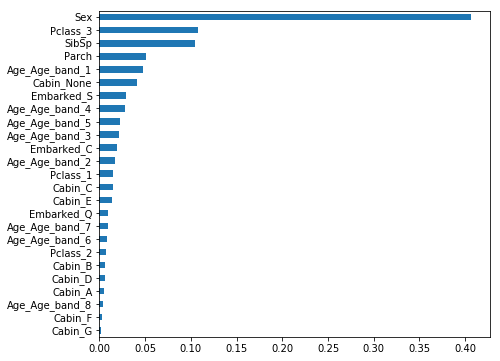

In [40]:
%matplotlib inline
#feature = pd.Series(model.feature_importances_, index=x.columns)
#feature.sort()
srt.plot(kind='barh', figsize=(7,6))

In [41]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(x,y)

2.83 s ± 37.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(x,y)

3.03 s ± 144 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


30 Trees
C-stat 0.827751680354
 
50 Trees
C-stat 0.831120378359
 
100 Trees
C-stat 0.829969961333
 
200 Trees
C-stat 0.831549121742
 
500 Trees
C-stat 0.832851329903
 
1000 Trees
C-stat 0.831059129305
 
2000 Trees
C-stat 0.831197605428
 


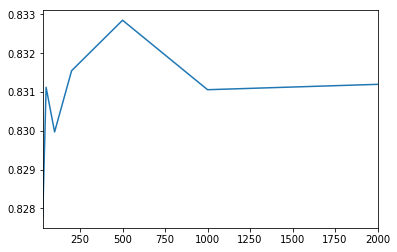

In [44]:
# n_estimator

result = []
n_estimator_option = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_option:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(x,y)
    print(trees, 'Trees')
    roc = roc_auc_score(y, model.oob_prediction_)
    print('C-stat', roc)
    result.append(roc)
    print(" ")

pd.Series(result, n_estimator_option).plot();

auto option
C-stat 0.831059129305
 
None option
C-stat 0.831059129305
 
sqrt option
C-stat 0.830925979186
 
log2 option
C-stat 0.831772813941
 
0.9 option
C-stat 0.831895312051
 
0.2 option
C-stat 0.830925979186
 


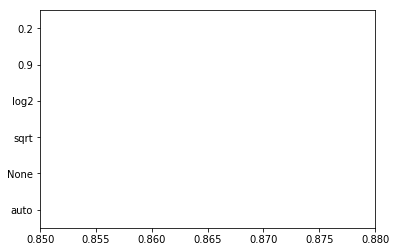

In [45]:
# Max_features 

result = []
max_feature_option = ['auto', None, 'sqrt', 'log2', 0.9,0.2]

for max_features in max_feature_option:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(x,y)
    print(max_features, 'option')
    roc = roc_auc_score(y, model.oob_prediction_)
    print('C-stat', roc)
    result.append(roc)
    print(' ')
   
pd.Series(result, max_feature_option).plot(kind="barh", xlim=(.85,.88))

1 min samples
C-stat 0.831059129305
 
2 min samples
C-stat 0.845279561989
 
3 min samples
C-stat 0.851335229391
 
4 min samples
C-stat 0.853231287082
 
5 min samples
C-stat 0.853689323491
 
6 min samples
C-stat 0.854014209781
 
7 min samples
C-stat 0.853513565334
 
8 min samples
C-stat 0.855020824679
 
9 min samples
C-stat 0.853726605524
 
10 min samples
C-stat 0.853247265097
 


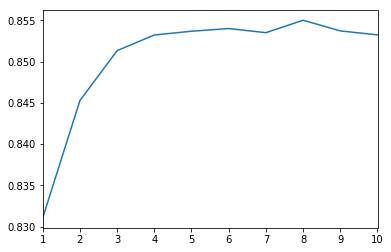

In [46]:
# min_sample_leaf

result =[]
min_sample_leaf_option = [1,2,3,4,5,6,7,8,9,10]

for min_samples in min_sample_leaf_option:
    model = RandomForestRegressor(n_estimators=1000,
                                 oob_score=True,
                                 n_jobs= -1,
                                 random_state= 42,
                                 max_features='auto',
                                 min_samples_leaf=min_samples)
    model.fit(x,y)
    print(min_samples, 'min samples')
    roc = roc_auc_score(y, model.oob_prediction_)
    print('C-stat', roc)
    result.append(roc)
    print(' ')

pd.Series(result, min_sample_leaf_option).plot()

In [218]:
# final model we find all best values

In [51]:
model = RandomForestRegressor(n_estimators=1000,
                             oob_score=True,
                             n_jobs=-1,
                             random_state=42,
                             max_features='auto',
                             min_samples_leaf=8)
model.fit(x,y)
roc= roc_auc_score(y, model.oob_prediction_)
print('C-stat : ', roc)

result= model.fit(x,y)

C-stat :  0.855020824679


In [52]:
result

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [53]:
x.head()

,Sex,SibSp,Parch,Age_Age_band_1,Age_Age_band_2,Age_Age_band_3,Age_Age_band_4,Age_Age_band_5,Age_Age_band_6,Age_Age_band_7,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Embarked_C,Embarked_Q,Embarked_S
0,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [54]:
test_data = pd.read_csv('dataset/test.csv')

In [55]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [56]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [57]:
test_data['Sex'].replace(['female','male'],[0,1],inplace=True)

In [58]:
PassengerId = test_data[['PassengerId']]

In [59]:
del test_data['Name']

In [60]:
del test_data['Ticket']

In [61]:
del test_data['PassengerId']

In [62]:
test_data['Age'].fillna(test_data['Age'].mean(), inplace=True)

In [63]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass      418 non-null int64
Sex         418 non-null int64
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


In [64]:
def clean_cabin(test_data):
    try:
        return test_data[0]
    except TypeError:
        return 'None'
test_data['Cabin'] = test_data['Cabin'].apply(clean_cabin)

In [65]:
test_data['Cabin'].head()

0    None
1    None
2    None
3    None
4    None
Name: Cabin, dtype: object

In [66]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass      418 non-null int64
Sex         418 non-null int64
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Cabin       418 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


In [67]:
test_data['Fare'].fillna(test_data['Fare'].mean(), inplace=True)

In [68]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass      418 non-null int64
Sex         418 non-null int64
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Cabin       418 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


In [69]:
test_data['Age'] = test_data['Age'].map(age_band)

In [70]:
test_data['Age'].value_counts(dropna=False)

Age_band_4    141
Age_band_3    131
Age_band_2     47
Age_band_5     46
Age_band_1     22
Age_band_6     20
Age_band_7     10
Age_band_8      1
Name: Age, dtype: int64

In [72]:
# create dummy variables at a time for all categorical variable

categorical_variable2 = ['Age','Pclass','Cabin','Embarked']

for variable2 in categorical_variable2:
    # create missing data wirth 'Missing' world
    test_data[variable2].fillna('Missing', inplace=True)
    # Create array od fummys
    dummies = pd.get_dummies(test_data[variable2], prefix=variable2)
    # Update  x to tindicate dummies and drop the main variable
    
    test_data= pd.concat([test_data, dummies], axis=1)
    test_data.drop([variable2], axis=1, inplace=True)

In [73]:
test_data.head()

,Sex,SibSp,Parch,Fare,Age_Age_band_1,Age_Age_band_2,Age_Age_band_3,Age_Age_band_4,Age_Age_band_5,Age_Age_band_6,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,7.8292,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,1,0,7.0000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2,1,0,0,9.6875,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1,0,0,8.6625,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,1,1,12.2875,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [74]:
x.head()

,Sex,SibSp,Parch,Age_Age_band_1,Age_Age_band_2,Age_Age_band_3,Age_Age_band_4,Age_Age_band_5,Age_Age_band_6,Age_Age_band_7,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Embarked_C,Embarked_Q,Embarked_S
0,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [77]:
del test_data['Fare']

In [78]:
# model.predict(test_data)
Survived= model.predict(test_data)

In [79]:
type(test_data)

pandas.core.frame.DataFrame

In [80]:
type(Survived)

numpy.ndarray

In [81]:
Survived = np.where(Survived > 0.5, 1, 0)

In [82]:
Survived
Survived = pd.DataFrame(Survived)

In [83]:
Survived=Survived.rename(columns = {0:'Survived'})
#type(Survived)
Survived.head()

,Survived
0,0
1,0
2,0
3,0
4,0


In [84]:
final = pd.concat([test_data,Survived], axis=1)

In [85]:
final.head()

,Sex,SibSp,Parch,Age_Age_band_1,Age_Age_band_2,Age_Age_band_3,Age_Age_band_4,Age_Age_band_5,Age_Age_band_6,Age_Age_band_7,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Embarked_C,Embarked_Q,Embarked_S,Survived
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [86]:
final = pd.concat([test_data,Survived], axis=1)

In [87]:
# result fo kaggle

kaggle = pd.concat([PassengerId, Survived], axis=1)

In [88]:
kaggle.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [89]:
kaggle.describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.327751
std,120.810458,0.469956
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [90]:
kaggle['Survived'].value_counts(dropna=False).head()

0    281
1    137
Name: Survived, dtype: int64

In [91]:
pd.DataFrame.to_csv(kaggle, path_or_buf='Submission14.csv',index=False)